<a href="https://colab.research.google.com/github/ArchitBhonsle/Efficient_AI/blob/main/CS7150_Project_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading MNIST dataset...
Training samples: 54000
Validation samples: 6000
Test samples: 10000

Training Logistic Regression
Using device: cuda
Model parameters: 7,850 (0.06 MB)


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Evaluating final model...
Final Train Loss: 0.2432, Train Acc: 0.9323
Final Test Loss: 0.2784, Test Acc: 0.9221

Training and Testing Metrics:
Final Train Loss: 0.2432, Train Acc: 0.9323
Final Test Loss: 0.2784, Test Acc: 0.9221
Model Parameters: 7,850 (0.06 MB)


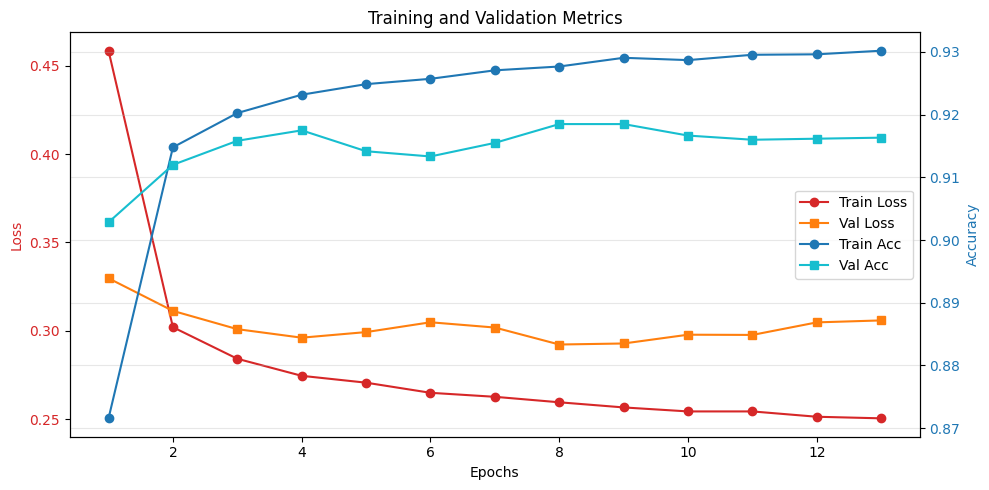

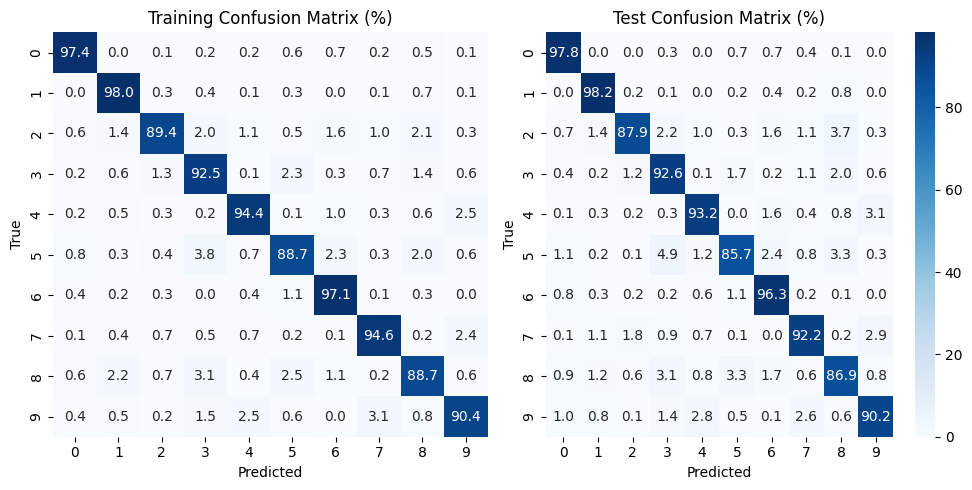

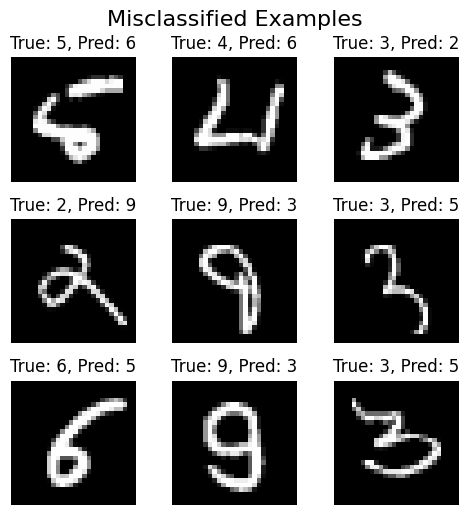


Training Shallow Neural Network
Using device: cuda
Model parameters: 118,282 (0.90 MB)


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating final model...
Final Train Loss: 0.0148, Train Acc: 0.9957
Final Test Loss: 0.0675, Test Acc: 0.9823

Training and Testing Metrics:
Final Train Loss: 0.0148, Train Acc: 0.9957
Final Test Loss: 0.0675, Test Acc: 0.9823
Model Parameters: 118,282 (0.90 MB)


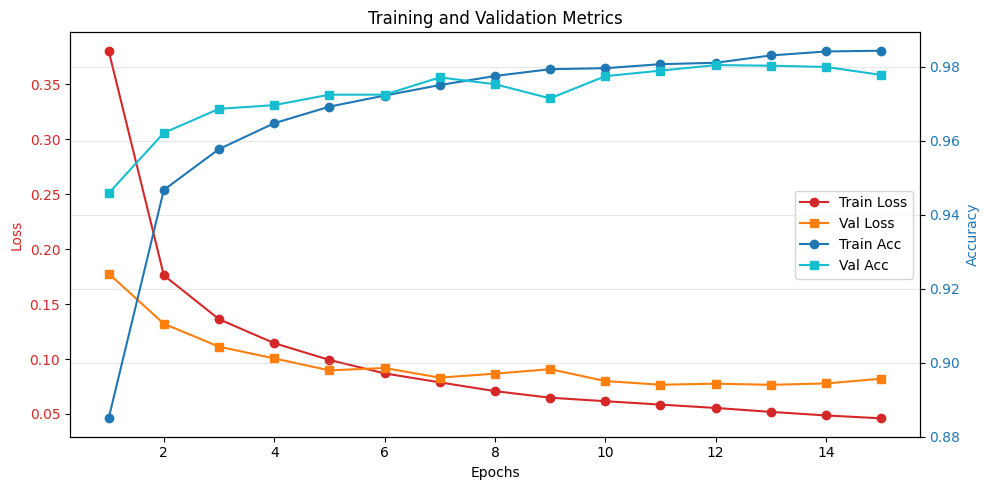

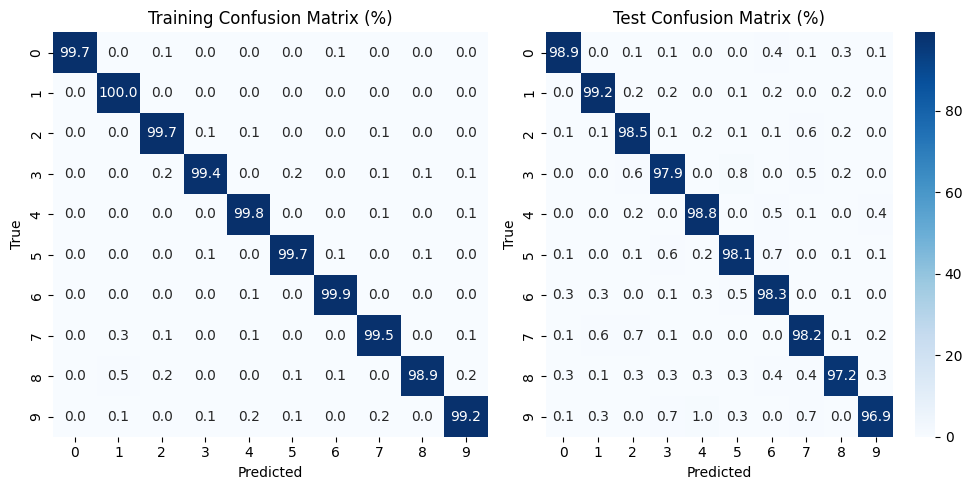

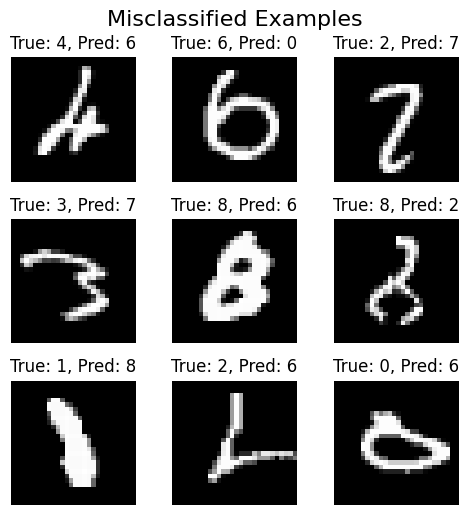


Training Deep Neural Network
Using device: cuda
Model parameters: 578,794 (4.42 MB)


Training Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Evaluating final model...
Final Train Loss: 0.0173, Train Acc: 0.9954
Final Test Loss: 0.0707, Test Acc: 0.9833

Training and Testing Metrics:
Final Train Loss: 0.0173, Train Acc: 0.9954
Final Test Loss: 0.0707, Test Acc: 0.9833
Model Parameters: 578,794 (4.42 MB)


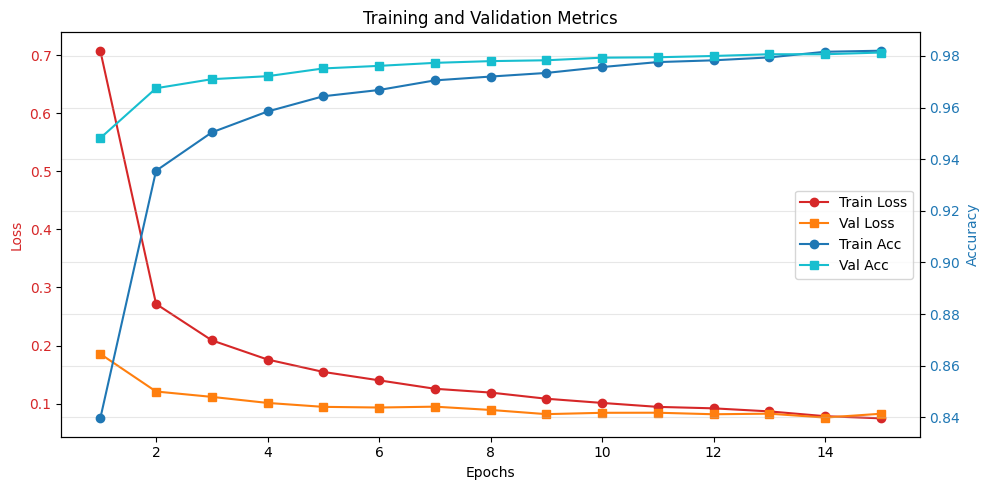

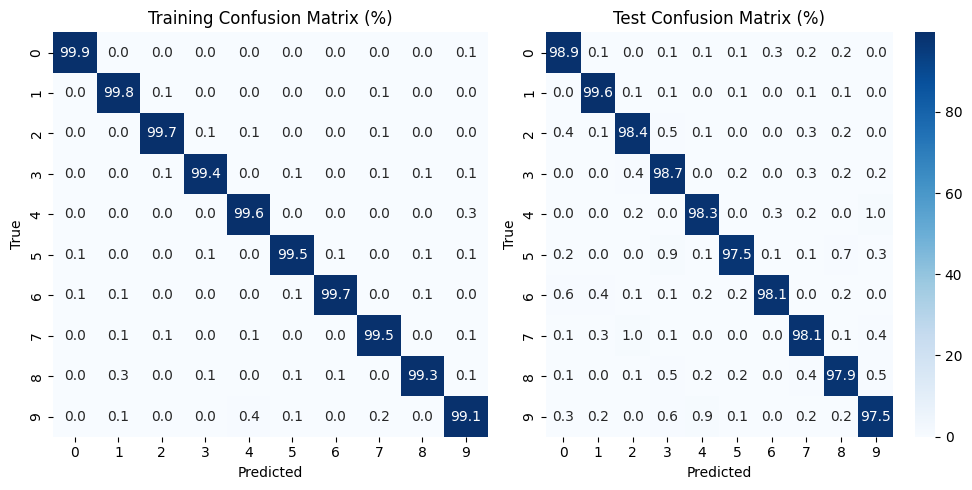

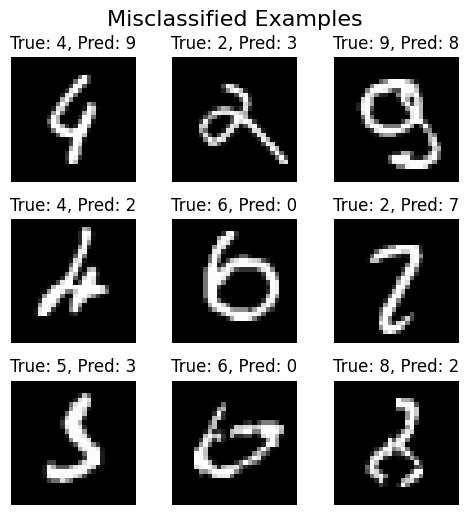

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict, Optional, Union, Callable, Any, Type
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
from collections import OrderedDict
from IPython.display import display, HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define data loading function
def load_mnist_data(
    batch_size: int = 64,
    validation_split: float = 0.1
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Load and prepare MNIST dataset with train/val/test splits

    Args:
        batch_size: Size of mini-batches
        validation_split: Fraction of training data to use for validation

    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Download and load the training data
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Download and load the test data
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Split training data into train and validation
    val_size = int(len(train_dataset) * validation_split)
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Training samples: {train_size}")
    print(f"Validation samples: {val_size}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

# Define models
class LogisticRegression(nn.Module):
    """Simple logistic regression model for MNIST"""

    def __init__(self) -> None:
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.linear(x)

class ShallowNN(nn.Module):
    """Slightly deeper neural network with a few hidden layers"""

    def __init__(
        self,
        hidden_size: int = 128,
        dropout_rate: float = 0.2
    ) -> None:
        super(ShallowNN, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.layers(x)

class DeepNN(nn.Module):
    """Deep neural network with multiple hidden layers"""

    def __init__(
        self,
        hidden_sizes: List[int] = [512, 256, 128, 64, 32],
        dropout_rate: float = 0.3,
        use_batch_norm: bool = True
    ) -> None:
        super(DeepNN, self).__init__()
        self.flatten = nn.Flatten()

        # Build layers dynamically
        layers = OrderedDict()
        input_size = 28 * 28

        for i, hidden_size in enumerate(hidden_sizes):
            # Add linear layer
            layers[f'linear{i}'] = nn.Linear(input_size, hidden_size)

            # Add batch normalization if requested
            if use_batch_norm:
                layers[f'batchnorm{i}'] = nn.BatchNorm1d(hidden_size)

            # Add activation
            layers[f'relu{i}'] = nn.ReLU()

            # Add dropout
            layers[f'dropout{i}'] = nn.Dropout(dropout_rate)

            # Update input size for next layer
            input_size = hidden_size

        # Output layer
        layers['output'] = nn.Linear(input_size, 10)

        self.layers = nn.Sequential(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        return self.layers(x)

def count_parameters(model: nn.Module) -> Tuple[int, float]:
    """
    Count the number of trainable parameters in a model and calculate memory footprint

    Args:
        model: PyTorch model

    Returns:
        Tuple of (number of trainable parameters, memory footprint in MB)
    """
    # Count parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Calculate memory footprint (assuming float32/4 bytes per parameter)
    # Include both parameters and gradients in the calculation
    param_size_bytes = num_params * 4  # Parameters (float32)
    grad_size_bytes = num_params * 4   # Gradients (float32)
    total_size_bytes = param_size_bytes + grad_size_bytes

    # Convert to MB
    total_size_mb = total_size_bytes / (1024 * 1024)

    return num_params, total_size_mb

def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
) -> Tuple[float, float]:
    """
    Train the model for one epoch

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: Device to run on (CPU/GPU)

    Returns:
        Tuple of (average loss, accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Process batches without creating a new progress bar
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
) -> Tuple[float, float, torch.Tensor, torch.Tensor, List[Dict[str, Any]]]:
    """
    Evaluate the model on given data

    Args:
        model: PyTorch model
        data_loader: DataLoader for evaluation data
        criterion: Loss function
        device: Device to run on (CPU/GPU)

    Returns:
        Tuple of (average loss, accuracy, all predictions, all targets, misclassified data)
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    misclassified_data = []

    with torch.no_grad():
        # Evaluate without creating a new progress bar
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            # Store predictions and targets for confusion matrix
            all_predictions.append(predicted.cpu())
            all_targets.append(targets.cpu())

            # Store misclassified examples
            misclassified_mask = (predicted != targets)
            if misclassified_mask.any():
                misclassified_inputs = inputs[misclassified_mask]
                misclassified_targets = targets[misclassified_mask]
                misclassified_predictions = predicted[misclassified_mask]

                for i in range(len(misclassified_inputs)):
                    if len(misclassified_data) < 100:  # Limit to 100 examples
                        misclassified_data.append({
                            'input': misclassified_inputs[i].cpu(),
                            'target': misclassified_targets[i].item(),
                            'prediction': misclassified_predictions[i].item()
                        })

    # Calculate average loss and accuracy
    eval_loss = running_loss / total
    eval_acc = correct / total

    all_predictions = torch.cat(all_predictions)
    all_targets = torch.cat(all_targets)

    return eval_loss, eval_acc, all_predictions, all_targets, misclassified_data

def train_and_evaluate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int = 10,
    lr: float = 0.001,
    device: Optional[torch.device] = None,
    early_stopping_patience: int = 5
) -> Dict[str, Any]:
    """
    Train and evaluate a model, with visualization of results

    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to run on (CPU/GPU)
        early_stopping_patience: Number of epochs to wait before early stopping

    Returns:
        Dictionary with training results and statistics
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")
    model = model.to(device)

    # Print model parameter count and memory footprint
    num_params, memory_mb = count_parameters(model)
    print(f"Model parameters: {num_params:,} ({memory_mb:.2f} MB)")

    # Set up optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Track metrics
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Early stopping variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    best_model_state = None

    # Create progress bar for all epochs
    progress_bar = tqdm(range(epochs), desc="Training Progress")

    # Train the model
    for epoch in progress_bar:
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update progress bar description with metrics
        progress_bar.set_description(
            f"Epoch {epoch+1}/{epochs} - "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} - "
            f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
        )

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                progress_bar.write(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # Final evaluation on training and test sets
    print("Evaluating final model...")
    train_loss, train_acc, train_preds, train_targets, _ = evaluate(
        model, train_loader, criterion, device
    )
    test_loss, test_acc, test_preds, test_targets, misclassified_data = evaluate(
        model, test_loader, criterion, device
    )

    print(f"Final Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Compile results
    results = {
        'model': model,
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'final_train_loss': train_loss,
        'final_train_acc': train_acc,
        'final_test_loss': test_loss,
        'final_test_acc': test_acc,
        'train_preds': train_preds,
        'train_targets': train_targets,
        'test_preds': test_preds,
        'test_targets': test_targets,
        'num_params': (num_params, memory_mb),
        'misclassified_data': misclassified_data
    }

    return results

def plot_training_curves(results: Dict[str, Any]) -> None:
    """
    Plot training and validation loss and accuracy curves

    Args:
        results: Dictionary with training results
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot loss curves on left y-axis
    epochs = range(1, len(results['train_losses']) + 1)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, results['train_losses'], 'o-', color='tab:red', label='Train Loss')
    ax1.plot(epochs, results['val_losses'], 's-', color='tab:orange', label='Val Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs, results['train_accs'], 'o-', color='tab:blue', label='Train Acc')
    ax2.plot(epochs, results['val_accs'], 's-', color='tab:cyan', label='Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.title('Training and Validation Metrics')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results: Dict[str, Any]) -> None:
    """
    Plot confusion matrices for training and test sets

    Args:
        results: Dictionary with training results
    """
    # Calculate confusion matrices
    train_cm = confusion_matrix(
        results['train_targets'], results['train_preds']
    )
    test_cm = confusion_matrix(
        results['test_targets'], results['test_preds']
    )

    # Convert to percentages (normalize by row)
    train_cm_percent = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis] * 100
    test_cm_percent = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis] * 100

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Plot training confusion matrix
    sns.heatmap(
        train_cm_percent,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        ax=ax1,
        cbar=False
    )
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_title('Training Confusion Matrix (%)')

    # Plot test confusion matrix
    sns.heatmap(
        test_cm_percent,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        ax=ax2,
        cbar=True
    )
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title('Test Confusion Matrix (%)')

    plt.tight_layout()
    plt.show()

def plot_misclassified_examples(results: Dict[str, Any], num_examples: int = 9) -> None:
    """
    Plot examples of misclassified digits

    Args:
        results: Dictionary with training results
        num_examples: Number of examples to show (must be a perfect square)
    """
    # Get misclassified examples
    misclassified = results['misclassified_data']

    if len(misclassified) < num_examples:
        print(f"Only {len(misclassified)} misclassified examples available.")
        num_examples = min(len(misclassified), 9)  # Default to 9 or fewer

    # Calculate grid dimensions
    grid_size = int(np.sqrt(num_examples))
    if grid_size**2 != num_examples:
        grid_size = int(np.sqrt(9))  # Default to 3x3 grid
        num_examples = grid_size**2

    # Set up the plot
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
    axes = axes.flatten()

    # Plot each misclassified example
    for i in range(num_examples):
        example = misclassified[i]
        img = example['input'].squeeze().numpy()
        true_label = example['target']
        pred_label = example['prediction']

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle('Misclassified Examples', y=1.02, fontsize=16)
    plt.show()

def run_experiment(
    model_class: Type[nn.Module],
    model_name: str,
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    model_kwargs: Dict[str, Any] = {},
    train_kwargs: Dict[str, Any] = {}
) -> None:
    """
    Run a complete experiment with a given model

    Args:
        model_class: PyTorch model class to instantiate
        model_name: Name of the model for display
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        test_loader: DataLoader for test data
        model_kwargs: Keyword arguments for model initialization
        train_kwargs: Keyword arguments for training
    """
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}")

    # Create model
    model = model_class(**model_kwargs)

    # Train and evaluate
    results = train_and_evaluate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        **train_kwargs
    )

    # Display results
    num_params, memory_mb = results['num_params']
    print("\nTraining and Testing Metrics:")
    print(f"Final Train Loss: {results['final_train_loss']:.4f}, Train Acc: {results['final_train_acc']:.4f}")
    print(f"Final Test Loss: {results['final_test_loss']:.4f}, Test Acc: {results['final_test_acc']:.4f}")
    print(f"Model Parameters: {num_params:,} ({memory_mb:.2f} MB)")

    # Plot results
    plot_training_curves(results)
    plot_confusion_matrices(results)
    plot_misclassified_examples(results)

# Main execution
def main() -> None:
    """Main function to run experiments"""
    print("Loading MNIST dataset...")
    train_loader, val_loader, test_loader = load_mnist_data(batch_size=128)

    # Define training settings
    train_settings = {
        'epochs': 15,
        'lr': 0.001,
        'early_stopping_patience': 5
    }

    # Run logistic regression experiment
    run_experiment(
        model_class=LogisticRegression,
        model_name="Logistic Regression",
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        train_kwargs=train_settings
    )

    # Run shallow neural network experiment
    run_experiment(
        model_class=ShallowNN,
        model_name="Shallow Neural Network",
        model_kwargs={'hidden_size': 128, 'dropout_rate': 0.2},
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        train_kwargs=train_settings
    )

    # Run deep neural network experiment
    run_experiment(
        model_class=DeepNN,
        model_name="Deep Neural Network",
        model_kwargs={
            'hidden_sizes': [512, 256, 128, 64, 32],
            'dropout_rate': 0.3,
            'use_batch_norm': True
        },
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        train_kwargs=train_settings
    )

# Execute main function
if __name__ == "__main__":
    main()